In [1]:
"""
Name: con_benchmark.ipynb
Authors: Stephan Meighen-Berger
Constructs the benchmark plots to compare with the other models
"""
%load_ext autoreload
%autoreload 2

In [2]:
 # General imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
from tqdm import tqdm

In [3]:
# Adding path to module
sys.path.append("../")

In [4]:
# picture path
PICS = '../pics/'

In [5]:
# Module imports
from contagion import Contagion, config
from contagion.config import _baseconfig
import yaml

In [6]:
parameters = {'incub dur mean': 2.737370669627129, 'inf prob max': 0.32734761993874756, 'infectious dur mean': 8.083432306043921, 'latency mean': 4.076925550609567, 'recovery dur mean': 1.9784900019430545, 'soc circ mean': 5.835203520366172}
my_config = yaml.safe_load(open("benchmark_config.yaml"))

def model(parameters, variance_mode):
    this_config = dict(_baseconfig)
    this_config.update(my_config)
    this_config['population']['social circle pdf']["mean"] = parameters["soc circ mean"]        
    this_config['population']['social circle interactions pdf']["mean"] = parameters["soc circ mean"]        
    this_config['infection']["latency duration pdf"]['mean'] =  parameters["latency mean"]        
    this_config['infection']["infectious duration pdf"]['mean'] =  parameters["infectious dur mean"]        
    this_config['infection']["recovery time pdf"]['mean'] =  parameters["recovery dur mean"]        
    this_config['infection']["incubation duration pdf"]['mean'] =  parameters["incub dur mean"]        
    this_config['infection']["infection probability pdf"]['max_val'] =  parameters["inf prob max"]        
    this_config['infection']["incubation duration pdf"]['sd'] =  np.sqrt(parameters["incub dur mean"])

    if variance_mode == "mean":
        this_config['infection']["recovery time pdf"]['sd'] =  np.sqrt(parameters["recovery dur mean"])
        this_config['infection']["infectious duration pdf"]['sd'] =  np.sqrt(parameters["infectious dur mean"])
        this_config['infection']["latency duration pdf"]['sd'] =  np.sqrt(parameters["latency mean"])
        this_config['population']['social circle interactions pdf']["sd"] = np.sqrt(parameters["soc circ mean"])
        this_config['population']['social circle pdf']["sd"] = np.sqrt(parameters["soc circ mean"])
    elif variance_mode == "minimal":
        this_config['infection']["recovery time pdf"]['sd'] =  0.1
        this_config['infection']["infectious duration pdf"]['sd'] =  0.1
        this_config['infection']["latency duration pdf"]['sd'] =  0.1
        this_config['population']['social circle interactions pdf']["sd"] = 0.1
        this_config['population']['social circle pdf']["sd"] = 0.1            
    else:
        raise RuntimeError("Unknown variance mode: {}".format(args.variance_mode))

    this_config["population"]["re-use population"] = False
    this_config["general"]["random state seed"] = parameters["seed"]
    contagion = Contagion(userconfig=this_config)
    contagion.sim()

    stats = contagion.statistics
    stats = pd.DataFrame(contagion.statistics)
    stats["is_recovered"] = stats["is_recovered"] + stats["is_recovering"]
    
    return stats, contagion.trace_infection


In [9]:
stats_arr = []
t_s_arr = []
for seed in tqdm(range(10)):
    parameters["seed"] = seed
    stats, t_i = model(parameters, "minimal")
    stats_arr.append(stats)
    t_s_arr.append(t_i)

100%|██████████████████████████████████████████| 10/10 [01:04<00:00,  6.47s/it]


In [10]:
max_len = 0
for s in stats_arr:
    max_len = max(max_len, len(s))
    
padded = []
for s in stats_arr:
    last = s.iloc[-1]
    padded.append(s.append([last]*(max_len - len(s))))

In [11]:
stats_arr = padded

In [12]:
# Averaging
stats = {}
for key in stats_arr[0].keys():
    stats[key] = np.average(np.array([
        stats_arr[i][key]
        for i in range(len(stats_arr))
    ]), axis=0)

In [13]:
 t_s_arr[0][0]

array([[[ 842, 3784]]], dtype=int64)

In [14]:
hist = np.zeros(10000)

In [15]:
r0 = []
reff = []
reff_hist = []
for tstep in t_s_arr[0]:
    tstep = np.atleast_2d(np.squeeze(tstep))
    if len(tstep) > 0:
        #print(tstep)
        inds, cnts = np.unique(tstep[:,0], return_counts=True)
        #print(inds, cnts)
        r0.append(sum(cnts) / len(inds))
        #hist[inds] += cnts
        #reff_hist.append()
    else:
        r0.append(0)
    

Text(0, 0.5, 'Current R0')

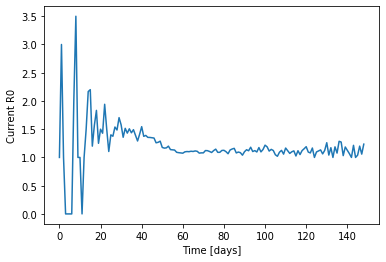

In [16]:
plt.plot(r0)
plt.xlabel("Time [days]")
plt.ylabel("Current R0")

In [17]:
# R_eff_steph
r_eff_arr_steph = []
for t_s in t_s_arr:
    try:
        edges_inf = np.unique(np.array(np.squeeze(np.hstack([i for i in t_s])).tolist()), axis=0)
        unique, counts = np.unique(edges_inf[:, 0], return_counts=True)
        counter_dic = dict(zip(unique, counts))
        day_to_day_infector = np.array([[i, np.unique(t_s[i][0][:, 0])] for i in range(len(t_s))])
        tmp = np.nan_to_num(np.array([
            np.average([counter_dic[day_inf[1][j]] if len(day_inf[1]) > 0 else 0 for j in range(len(day_inf[1]))])
            for day_inf in day_to_day_infector
        ]))
        extension = max_len - len(tmp)
        tmp_ext = np.concatenate((tmp, np.zeros(extension)))
        r_eff_arr_steph.append(tmp_ext)
    except:
        r_eff_arr_steph.append(np.zeros(max_len))
r_eff_steph = np.average(r_eff_arr_steph, axis=0)

C:\Users\Christian\Anaconda3\envs\covid19\lib\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Christian\Anaconda3\envs\covid19\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [18]:
def Unique(array, orderby='first'):
    array = np.asarray(array)
    order = array.argsort(kind='mergesort')
    array = array[order]
    diff = array[1:] != array[:-1]
    if orderby == 'first':
        diff = np.concatenate([[True], diff])
    elif orderby == 'last':
        diff = np.concatenate([diff, [True]])
    else:
        raise ValueError
    uniq = array[diff]
    index = order[diff]
    return uniq[index.argsort()]

In [19]:
# R_eff_tina
r_eff_arr_tina = []
for id_t_s, t_s in enumerate(t_s_arr):
    try:
        lower_id = 0
        edges_inf = np.unique(np.array(np.squeeze(np.hstack([i for i in t_s])).tolist()), axis=0)
        unique, counts = np.unique(edges_inf[:, 0], return_counts=True)
        counter_dic = dict(zip(unique, counts))
        sorted_infectors = Unique(np.hstack(np.array([day[0, :,0] for day in t_s])))
        r_eff_tina_tmp = []
        for i in range(max_len):
            newly_recovered = np.diff(stats_arr[id_t_s]['is_recovered'])
            newly_recovered = np.insert(newly_recovered, 0, 0)
            today_recovered = newly_recovered[i]
            upper_id = int(today_recovered + lower_id)
            todays_recovered_infectors = sorted_infectors[lower_id:upper_id]
            these_infected = np.sum(np.array([counter_dic[infec] for infec in todays_recovered_infectors]))
            lower_id = upper_id
            r_eff_tina_tmp.append(these_infected / len(todays_recovered_infectors))
        r_eff_tina_tmp = np.nan_to_num(np.array(r_eff_tina_tmp))
        r_eff_arr_tina.append(r_eff_tina_tmp)
    except:
        r_eff_arr_tina.append(np.zeros(max_len))
r_eff_tina = np.average(r_eff_arr_tina, axis=0)

<ipython-input-19-e4b469181f1e>:19: RuntimeWarning: invalid value encountered in double_scalars
  r_eff_tina_tmp.append(these_infected / len(todays_recovered_infectors))


In [20]:
# Fetching representative result
maxima_id = np.array([np.argmax(stats_arr[i]['is_infected']) for i in range(len(stats_arr))])
average_max_id = np.argmax(stats['is_infected'])
nearest_id = (np.abs(maxima_id - average_max_id)).argmin()
run_id = nearest_id

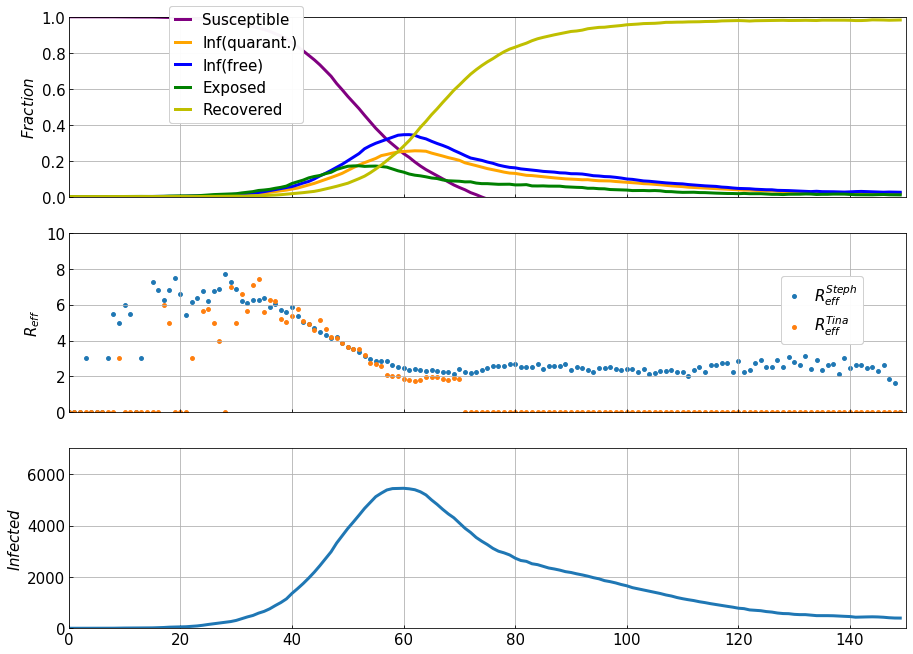

In [21]:
# Plotting standards
std_size = 15.
fontsize = 15.
lw=3.
h_length=1.
figure, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
colors = ['#fdcc8a',
          '#fc8d59',
          '#d7301f']
# ---------------------------------------------------------------------------------
# Infections per time step
time_steps = np.arange(max_len)

ax1.plot(time_steps,
         (config['population']['population size'] - stats_arr[run_id]['is_recovered'] + stats_arr[run_id]['is_recovering']-
          stats_arr[run_id]['is_infected']) /
         config['population']['population size'],
         lw=lw, label='Susceptible', color='purple')
ax1.plot(time_steps, stats_arr[run_id]['is_quarantined'] / config['population']['population size'],
         lw=lw, label='Inf(quarant.)', color='orange')
ax1.plot(time_steps, (stats_arr[run_id]['is_infectious']) / config['population']['population size'],
         lw=lw, label='Inf(free)', color='b')
ax1.plot(time_steps, (stats_arr[run_id]['is_latent']) / config['population']['population size'],
         lw=lw, label='Exposed', color="g")
ax1.plot(time_steps, stats_arr[run_id]['is_recovered'] / config['population']['population size'],
         lw=lw, label='Recovered', color='y')

# ax1.set_xlim(0, 200)
ax1.set_ylim(0., 1.)
ax1.set_xscale('linear')
ax1.set_yscale('linear')
# ax1.set_xlabel(r't [Days]', fontsize=fontsize)
ax1.set_ylabel(r'$Fraction$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(0.2, +1.1),
                  ncol=1, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=True)
ax1.add_artist(lgd1)
ax1.grid(True)
# ---------------------------------------------------------------------------------
# The effective R value
ax2.scatter(time_steps, r_eff_arr_steph[run_id], s=lw * 5, label=r'$R_{eff}^{Steph}$')
ax2.scatter(time_steps, r_eff_arr_tina[run_id], s=lw * 5, label=r'$R_{eff}^{Tina}$')
ax2.set_ylim(0., 10)
ax2.set_xscale('linear')
ax2.set_yscale('linear')
# ax1.set_xlabel(r't [Days]', fontsize=fontsize)
ax2.set_ylabel(r'$R_{eff}$', fontsize=fontsize)
ax2.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax2.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
h, l = ax2.get_legend_handles_labels()
lgd1 = ax2.legend(h,l, loc=9, bbox_to_anchor=(0.9, +0.8),
                  ncol=1, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=True)
ax2.add_artist(lgd1)
ax2.grid(True)
# ---------------------------------------------------------------------------------
# The number of infected people
ax3.plot(time_steps, stats_arr[run_id]['is_infected'], lw=lw)
ax3.set_xlim(0, 150)
ax3.set_ylim(0., 7000)
ax3.set_xscale('linear')
ax3.set_yscale('linear')
# ax1.set_xlabel(r't [Days]', fontsize=fontsize)
ax3.set_ylabel(r'$Infected$', fontsize=fontsize)
ax3.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax3.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax3.grid(True)
plt.show()

In [22]:
figure.savefig(PICS + "Contagion_Benchmark.png",
               bbox_inches='tight')

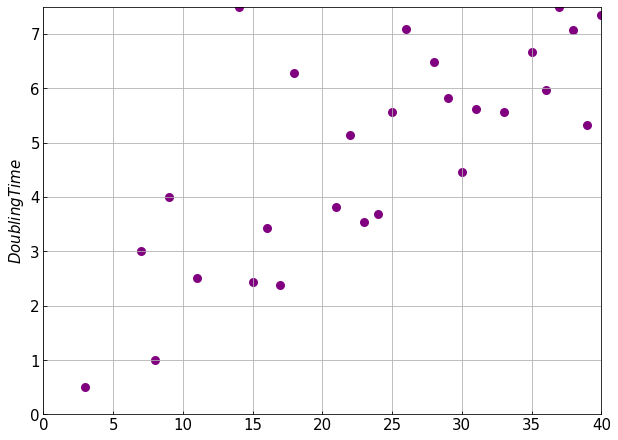

In [23]:
# Plotting standards
std_size = 10.
fontsize = 15.
lw=3.
h_length=1.
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
colors = ['#fdcc8a',
          '#fc8d59',
          '#d7301f']
# ---------------------------------------------------------------------------------
# Infections per time step
ax1.scatter(time_steps[:-1],
            stats_arr[run_id]['is_infected'][:-1] / np.diff(stats_arr[run_id]['is_infected']),
            lw=lw, label='Doubling Time', color='purple')
ax1.set_xlim(0, 40)
ax1.set_ylim(0., 7.5)
ax1.set_xscale('linear')
ax1.set_yscale('linear')
# ax1.set_xlabel(r't [Days]', fontsize=fontsize)
ax1.set_ylabel(r'$Doubling Time$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
# h, l = ax1.get_legend_handles_labels()
# lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(0.8, +1.1),
#                   ncol=1, fontsize=fontsize, handlelength=h_length,
#                   fancybox=True, frameon=True)
# ax1.add_artist(lgd1)
ax1.grid(True)
plt.show()

In [51]:
results = pd.DataFrame(
    {"susceptible": config['population']['population size'] - stats_arr[run_id]['is_recovered'] -
          stats_arr[run_id]['is_infected'],
     "exposed": stats_arr[run_id]['is_latent'],
    "infectious": stats_arr[run_id]['is_infectious'],
    
    "recovered": stats_arr[run_id]['is_recovered']
    })
results.to_csv("results.csv", index=False, sep=";")    
        

In [71]:
stats_arr[0].columns

Index(['is_removed', 'is_latent', 'is_infectious', 'is_infected',
       'is_hospitalized', 'is_recovered', 'is_dead', 'is_quarantined',
       'is_symptomatic'],
      dtype='object')

In [ ]:
np.savetxt("Result.csv", )

In [57]:
np.savetxt('Exposed.csv', stats_arr[run_id]['is_latent'], delimiter=",")
np.savetxt('Susceptible.csv', config['population']['population size'] - stats_arr[run_id]['is_recovered'] -
          stats_arr[run_id]['is_infected'], delimiter=",")
np.savetxt('Infectious.csv', stats_arr[run_id]['is_infectious'], delimiter=",")
np.savetxt('Recovered.csv', stats_arr[run_id]['is_recovered'], delimiter=",")